In [3]:
import pandas as pd
import numpy as np
import re
import pickle
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations
import json, os
from collections import OrderedDict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

from matplotlib import pyplot

In [4]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('../../BPIC_Classification/processed_dataset/P_BPIC12_agg.csv')
df.head()

,A_SUBMITTED-COMPLETE,A_PARTLYSUBMITTED-COMPLETE,A_PREACCEPTED-COMPLETE,W_Completeren aanvraag-SCHEDULE,W_Completeren aanvraag-START,A_ACCEPTED-COMPLETE,O_SELECTED-COMPLETE,A_FINALIZED-COMPLETE,O_CREATED-COMPLETE,O_SENT-COMPLETE,W_Nabellen offertes-SCHEDULE,W_Completeren aanvraag-COMPLETE,W_Nabellen offertes-START,W_Nabellen offertes-COMPLETE,O_SENT_BACK-COMPLETE,W_Valideren aanvraag-SCHEDULE,W_Valideren aanvraag-START,A_REGISTERED-COMPLETE,A_APPROVED-COMPLETE,O_ACCEPTED-COMPLETE,A_ACTIVATED-COMPLETE,W_Valideren aanvraag-COMPLETE,O_CANCELLED-COMPLETE,W_Wijzigen contractgegevens-SCHEDULE,A_DECLINED-COMPLETE,A_CANCELLED-COMPLETE,W_Afhandelen leads-SCHEDULE,W_Afhandelen leads-START,W_Afhandelen leads-COMPLETE,O_DECLINED-COMPLETE,W_Nabellen incomplete dossiers-SCHEDULE,W_Nabellen incomplete dossiers-START,W_Nabellen incomplete dossiers-COMPLETE,W_Beoordelen fraude-SCHEDULE,W_Beoordelen fraude-START,W_Beoordelen fraude-COMPLETE,112.0,Unnamed: 37,10862.0,10913.0,11049.0,10629.0,11120.0,10809.0,10912.0,11201.0,11119.0,10861.0,11203.0,11181.0,11189.0,10609.0,11111.0,10982.0,11019.0,11180.0,10899.0,10138.0,11002.0,11122.0,10889.0,10972.0,11121.0,10939.0,11029.0,11009.0,11000.0,10863.0,11169.0,11179.0,11001.0,10971.0,10228.0,11202.0,10789.0,10881.0,10909.0,10188.0,10910.0,10929.0,10931.0,11259.0,11200.0,10779.0,10880.0,10914.0,10859.0,11339.0,10933.0,11079.0,10932.0,10935.0,11254.0,11003.0,10125.0,11269.0,10821.0,11289.0,10124.0,11299.0,11309.0,11300.0,11302.0,11319.0,11304.0,Complete Timestamp,label,Variant,AMOUNT,A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,A_ACCEPTED,O_SELECTED,A_FINALIZED,O_CREATED,O_SENT,W_Nabellen offertes,O_SENT_BACK,W_Valideren aanvraag,A_REGISTERED,A_APPROVED,O_ACCEPTED,A_ACTIVATED,O_CANCELLED,W_Wijzigen contractgegevens,A_DECLINED,A_CANCELLED,W_Afhandelen leads,O_DECLINED,W_Nabellen incomplete dossiers,W_Beoordelen fraude,COMPLETE,SCHEDULE,START
0,1,1,1,1,1,1,1,1,1,1,1,1,3,3,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,5,2,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011-10-06 09:44:45.718269184,1,Variant 613,20000,1,1,1,3,1,1,1,1,1,7,1,3,1,1,1,1,0,0,0,0,0,0,0,0,18,3,5
1,1,1,1,1,2,1,2,1,2,2,2,2,4,4,1,1,3,1,1,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,12,5,0,4,0,4,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011-10-05 13:15:29.379769344,1,Variant 614,5000,1,1,1,5,1,2,1,2,2,10,1,7,1,1,1,1,1,0,0,0,0,0,0,0,26,4,9
2,1,1,1,1,4,1,3,1,3,3,3,4,11,11,1,1,1,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0,0,4,0,0,0,5,17,4,7,2,2,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011-10-18 03:47:58.488067584,0,Variant 615,7000,1,1,1,9,1,3,1,3,3,25,1,3,1,1,1,1,2,1,0,0,0,0,0,0,37,6,16
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011-10-01 15:11:21.440333312,1,Variant 1,15000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011-10-01 15:15:53.677666560,1,Variant 1,5000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0


In [11]:
class AccuracyScore:

    def __init__(self, X_train, y_train, X_test, y_test):
        self.self = self
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def preprocessing(self):
        self['Complete Timestamp'] = pd.to_datetime(self['Complete Timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
        self['Complete Timestamp'] = (self['Complete Timestamp'] - self['Complete Timestamp'].min()) / np.timedelta64(1,'M')
        
        for i in self['Variant']:
            self['Variant'] = self['Variant'].str.replace('Variant', '')

        self['Variant'] = self['Variant'].astype(int)

        return df
    
    def data_split(self):
        X = df.drop('label', axis=1)
        y = df['label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023, shuffle=True)
        
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        
        return X_train, y_train, X_test, y_test        
    
    def imbalance(self, X_train, y_train):
        sm = SMOTE(random_state=1)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        return X_train_res, y_train_res
    
    def DT(self, X_train, y_train, X_test, y_test):
        clf_dt = tree.DecisionTreeClassifier(max_depth=2, random_state=2023)
        clf_dt = clf_dt.fit(X_train, y_train)
        predictions = clf_dt.predict(X_test)
        accuracy = clf_dt.score(X_test, y_test)
        print('DT Accuracy:', accuracy)
        print('DT AUC Score {}'.format(roc_auc_score(y_test, predictions)))

    def RF(self, X_train, y_train, X_test, y_test):
        clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2023)
        clf_rf = clf_rf.fit(X_train, y_train)
        predictions = clf_rf.predict(X_test)
        accuracy = clf_rf.score(X_test, y_test)
        print('RF Accuracy:', accuracy)
        print('RF AUC Score {}'.format(roc_auc_score(y_test, predictions)))
    
    def XGB(self, X_train, y_train, X_test, y_test):
        xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=2023)
        xgb.fit(X_train, y_train)
        predictions = xgb.predict(X_test)
        accuracy = xgb.score(X_test, y_test)
        print('XGB Accuracy:', accuracy)
        print('XGB AUC Score {}'.format(roc_auc_score(y_test, predictions)))
    
    def LGBM(self, X_train, y_train, X_test, y_test):
        lgbm = LGBMClassifier(random_state=2023)
        lgbm = lgbm.fit(X_train, y_train)
        predictions = lgbm.predict(X_test)
        accuracy = lgbm.score(X_test, y_test)
        print('LGBM Accuracy:', accuracy)
        print('LGBM AUC Score {}'.format(roc_auc_score(y_test, predictions)))

In [6]:
df = AccuracyScore.preprocessing(df)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train, y_train, X_test, y_test = AccuracyScore.data_split(df)
X_train, y_train = AccuracyScore.imbalance(df, X_train, y_train)

In [12]:
AccuracyScore.DT(df, X_train, y_train, X_test, y_test)
AccuracyScore.RF(df, X_train, y_train, X_test, y_test)
AccuracyScore.XGB(df, X_train, y_train, X_test, y_test)
AccuracyScore.LGBM(df, X_train, y_train, X_test, y_test)

DT Accuracy: 0.8838808250572956
DT AUC Score 0.4420529801324503
RF Accuracy: 0.8186911128087598
RF AUC Score 0.9093224656138563
XGB Accuracy: 0.9997453526865292
XGB AUC Score 0.5
LGBM Accuracy: 0.9997453526865292
LGBM AUC Score 0.5


In [8]:
dt_model = DecisionTreeClassifier(max_depth=2, random_state=2023)
dt_model.fit(X_train, y_train)
prediction = dt_model.predict(X_test)
print('AUC Score {}'.format(roc_auc_score(y_test, prediction)))

AUC Score 0.4420529801324503


In [ ]:
# overfitting을 피하기 위한 시도들....

[0]	validation_0-error:0.00000	validation_0-logloss:0.43767	validation_1-error:0.00000	validation_1-logloss:0.43767
[1]	validation_0-error:0.00000	validation_0-logloss:0.29651	validation_1-error:0.00000	validation_1-logloss:0.29650
[2]	validation_0-error:0.00000	validation_0-logloss:0.20754	validation_1-error:0.00000	validation_1-logloss:0.20754
[3]	validation_0-error:0.00000	validation_0-logloss:0.14802	validation_1-error:0.00000	validation_1-logloss:0.14801
[4]	validation_0-error:0.00000	validation_0-logloss:0.10682	validation_1-error:0.00000	validation_1-logloss:0.10681
[5]	validation_0-error:0.00000	validation_0-logloss:0.07770	validation_1-error:0.00000	validation_1-logloss:0.07770
[6]	validation_0-error:0.00000	validation_0-logloss:0.05684	validation_1-error:0.00000	validation_1-logloss:0.05683
[7]	validation_0-error:0.00000	validation_0-logloss:0.04175	validation_1-error:0.00000	validation_1-logloss:0.04174
[8]	validation_0-error:0.00000	validation_0-logloss:0.03076	validation_1

C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[43]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[44]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[45]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[46]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[47]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[48]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[49]	validation_0-error:0.00000	validation_0-logloss:0.00020	validation_1-error:0.00000	validation_1-logloss:0.00020
[50]	validation_0-error:0.00000	validation_0-logloss:0.00020	val

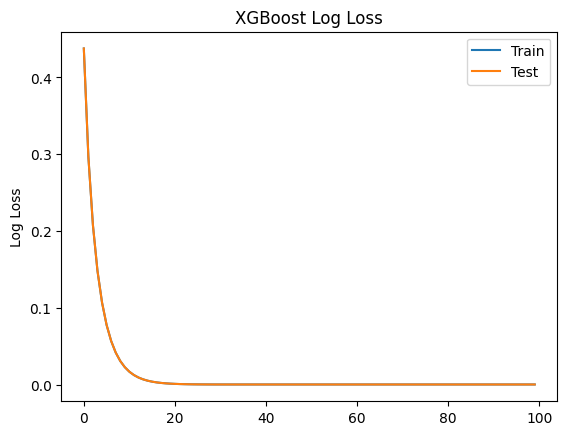

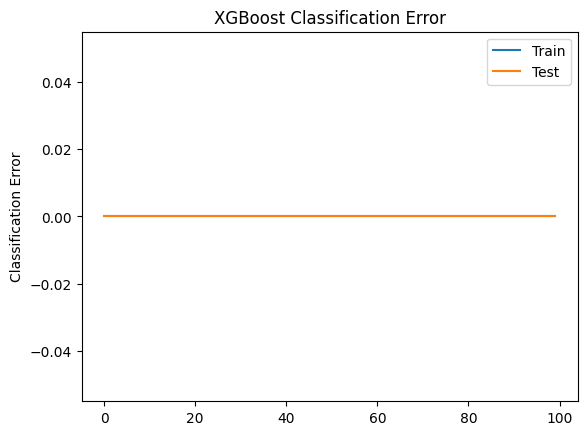

In [23]:
# plot log loss

model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [39]:
model = LGBMClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('LGBM Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('LGBM Classification Error')
pyplot.show()

[1]	training's binary_error: 0.174127	training's binary_logloss: 0.36787	valid_1's binary_error: 0.165011	valid_1's binary_logloss: 0.357578
[2]	training's binary_error: 0.174127	training's binary_logloss: 0.309138	valid_1's binary_error: 0.165011	valid_1's binary_logloss: 0.30099
[3]	training's binary_error: 0.174127	training's binary_logloss: 0.265539	valid_1's binary_error: 0.165011	valid_1's binary_logloss: 0.258847
[4]	training's binary_error: 0.174127	training's binary_logloss: 0.230936	valid_1's binary_error: 0.165011	valid_1's binary_logloss: 0.22532
[5]	training's binary_error: 0	training's binary_logloss: 0.202474	valid_1's binary_error: 0	valid_1's binary_logloss: 0.197693
[6]	training's binary_error: 0	training's binary_logloss: 0.178539	valid_1's binary_error: 0	valid_1's binary_logloss: 0.174425
[7]	training's binary_error: 0	training's binary_logloss: 0.158106	valid_1's binary_error: 0	valid_1's binary_logloss: 0.154538
[8]	training's binary_error: 0	training's binary_lo

C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


AttributeError: 'LGBMClassifier' object has no attribute 'evals_result'

In [31]:
params ={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf = RandomForestClassifier(random_state=2023, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

best_params = grid_cv.best_params_
best_score = grid_cv.best_score_

# print the best hyperparameters and score
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score:.4f}")

Best parameters: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
Best score: 0.9998


In [32]:
params ={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf = XGBClassifier(random_state=2023, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

best_params = grid_cv.best_params_
best_score = grid_cv.best_score_

# print the best hyperparameters and score
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score:.4f}")

[14:05:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

Best parameters: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
Best score: 1.0000


In [33]:
params ={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf = LGBMClassifier(random_state=2023, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

best_params = grid_cv.best_params_
best_score = grid_cv.best_score_

# print the best hyperparameters and score
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=8. Current value: min_data_in_leaf=8
[LightGBM] [Warning] Unknown parameter: min_samples_split
Best parameters: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
Best score: 1.0000


In [37]:
num_folds = 100

# define the cross-validation method
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# perform k-fold cross-validation
scores = cross_val_score(AccuracyScore.LGBM(df, X_train, y_train, X_test, y_test), X_train, y_train, cv=kf)

# print the average score and standard deviation of the scores
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

C:\Users\yeon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_error: 0.165011	valid_0's binary_logloss: 0.357578
[2]	valid_0's binary_error: 0.165011	valid_0's binary_logloss: 0.30099
[3]	valid_0's binary_error: 0.165011	valid_0's binary_logloss: 0.258847
[4]	valid_0's binary_error: 0.165011	valid_0's binary_logloss: 0.22532
[5]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.197693
[6]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.174425
[7]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.154538
[8]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.137361
[9]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.122407
[10]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.109309
[11]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.0977804
[12]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.0875938
[13]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.0785642
[14]	valid_0's binary_error: 0	valid_0's binary_logloss: 0.0705388
[15]	valid_0's binary_error: 0	valid_0's binary_logloss

TypeError: estimator should be an estimator implementing 'fit' method, None was passed